# TM10007 Assignment template

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [56]:
#general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from scipy import stats


# Classifiers
from sklearn import model_selection
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [4]:
# Data loading functions. Uncomment the one you want to use
import pandas as pd
from worcliver.load_data import load_data


data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 186
The number of columns: 494


### Dividing our data into test-, training- and validation-set

The dataset should be randomly divided into :
* training datasets = 70 % of samples
* test datasets = 20 % of samples
* validation datasets = 10 % of samples

In [5]:
amount_in_training = round(len(data.index)*0.7)
amount_in_test = round(len(data.index)*0.2)
amount_in_validation = len(data.index) - amount_in_training - amount_in_test

#split the data into training data and test+validation data
training_data, test_validation_data = model_selection.train_test_split(data, test_size=(amount_in_test + amount_in_validation) / len(data), random_state=42)

#split the test+validation data into seperate sets for test and validation
test_data, validation_data = model_selection.train_test_split(test_validation_data, test_size=amount_in_validation / (amount_in_test + amount_in_validation), random_state=42)

#checking the lengths
print(f'Training: {len(training_data)} samples, Test: {len(test_data)} samples, Validation: {len(validation_data)} samples.')
print(f'So total number of samples: {len(training_data)+len(test_data)+len(validation_data)}')

Training: 130 samples, Test: 37 samples, Validation: 19 samples.
So total number of samples: 186


### Extracting the label per patient

This label (benign/malignant) is the ground truth per patient.

In [6]:
label_training = training_data[['label']]
training_data.drop(columns=['label'], inplace=True)

label_training_binary = label_training.copy()
label_training_binary['label'] = label_training_binary['label'].map({'malignant': 1, 'benign': 0})


### Finding the missing data

Checking whether the missing data is stored as NaN or 0, finding the columns in which missing data is found as well as the empty features.


In [9]:
#making a dataframe
data_training = pd.DataFrame(training_data)

#checking whether missing data is stored as NaN
nan_check = data_training.isna()

#conclusion: missing data is not stored as NaN

#checking whether missing data is stored as 0
zero_counts = (data_training == 0).sum()

#conclusion: missing data is stored as 0

zero_counts_columns = zero_counts[zero_counts > 0]
print(f'The number of features in which there is missing data: {zero_counts_columns.count()}')
print(f'The number of missing data is: {sum(zero_counts_columns)}')

The number of features in which there is missing data: 29
The number of missing data is: 3046


### Handling the missing data

The missing data was handled as follows:
1. Deleting the empty features from the data
2. Replacing the missing data with the median value

In [45]:
#step 1: deleting the empty features from the data
#a feature is empty when it contains values for <30% of the samples
#   empty_features = the features that are considered empty
#   missing_data_features = the features that contain missing data
empty_features = []
missing_data_features = []

for feature, missing_data in zero_counts_columns.items():  
    if missing_data > 0.7*len(data_training.index):
        empty_features.append(feature)
    else:
        missing_data_features.append(feature)
        print(f'The amount of data missing in {feature} is {missing_data}')

data_training_clean = data_training.drop(columns=empty_features)
print(f'Empty features: {len(empty_features)}, Features with missing data: {len(missing_data_features)}.')



The amount of data missing in PREDICT_original_tf_LBP_quartile_range_R8_P24 is 31
The amount of data missing in PREDICT_original_phasef_monogenic_peak_WL3_N5 is 3
The amount of data missing in PREDICT_original_phasef_monogenic_peak_position_WL3_N5 is 3
The amount of data missing in PREDICT_original_phasef_phasecong_quartile_range_WL3_N5 is 22
The amount of data missing in PREDICT_original_phasef_phasesym_quartile_range_WL3_N5 is 47
Empty features: 24, Features with missing data: 5.


In [11]:
#step 2: replacing the missing data with the median
for feature in missing_data_features:
    data_training_clean[feature].replace(0, np.nan, inplace=True)
    
    # Vervang de NaN waarden door de mediaan
    median_value = data_training_clean[feature].median()
    data_training_clean[feature].fillna(median_value, inplace=True)

check_zero_counts = (data_training_clean == 0).sum()
check_zero_counts_columns = check_zero_counts[check_zero_counts > 0]
print(f'To check: the number of features in which there is missing data is now: {check_zero_counts_columns.count()}')

To check: the number of features in which there is missing data is now: 0


/var/folders/83/18qvb7f97tb0z2cjgkk_9bs00000gn/T/ipykernel_13938/1086206140.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_training_clean[feature].replace(0, np.nan, inplace=True)
/var/folders/83/18qvb7f97tb0z2cjgkk_9bs00000gn/T/ipykernel_13938/1086206140.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

### Pre-processing: standardization/normalization

First is tested whether the data is normally distributed or not with the Shapiro-Wilk Test. 
* p-value > 0.05: the data is likely normally distributed
* p-value < 0.05: the data is likely not normally distributed

In [12]:
shapiro_results = {}
no_variation = 0
features_no_variation = []

for feature in data_training_clean.columns:
    if data_training_clean[feature].max() == data_training_clean[feature].min():
        shapiro_results[feature] = None  #skipping the feature when there is no variation                   WILLEN WE DEZE FEATURE DAN OOK WISSEN?
        no_variation += 1
        features_no_variation.append(feature)
    else:
        #Shapiro-Wilk test to check for normality
        stat, p_value = stats.shapiro(data_training_clean[feature])

        #if normally distributed, store 1, else store 0
        if p_value > 0.05:
            result = 1
        else:
            result = 0

        shapiro_results[feature] = result

#the number of normally distributed features
print(f'The number of features that do not have variation in their values is: {no_variation}')
print(f'The number of normally distributed features is: {sum(1 for result in shapiro_results.values() if result == 1)}')


The number of features that do not have variation in their values is: 10
The number of normally distributed features is: 53


#### Standardization

In [ ]:
#code from workgroup; sklearn package has a function that standardizes the data, so this is applied here:
scaler = preprocessing.StandardScaler()
data_training_standardized = scaler.fit_transform(data_training_clean)
data_training_standardized_df = pd.DataFrame(data_training_standardized, columns=data_training_clean.columns)

print(data_training_standardized_df)

### Feature selection
#### Method 1: Least Absolute Shrinkage and Selection Operator Method 
* Size of alpha

1. Large alpha → More coefficients shrink to zero (more feature selection) 

2. Small alpha → Less regularization, more features kept.

* To find the best alpha, we will try different values of alpha and find the optimal value

* We can also tune the values total possible values of alpha and the number of segements for crossvalidation

In [ ]:
# First convert the label to categorial values (0 and 1)
encoder = LabelEncoder()
label_training_cat = encoder.fit_transform(label_training) 

label_training_cat = label_training_cat.ravel()

# Perform Lasso with cross-validation for 50 values of alpha on 10 segments
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv=10)  
lasso_cv.fit(data_training_standardized_df, label_training_cat)

# Best alpha value
best_alpha = lasso_cv.alpha_
print(f"Optimal Alpha: {best_alpha}")

# Fit LASSO again with optimal alpha
lasso_opt = Lasso(alpha=best_alpha)
lasso_opt.fit(data_training_standardized_df, label_training_cat)

# Get final selected features
selected_features = data_training_standardized_df.columns[lasso_opt.coef_ != 0]
print(f"Number of selected features: {len(selected_features)}")
print(f"Final Selected Features: {list(selected_features)} ")

training_data_selected = data_training_standardized_df[selected_features]
print(f"Size of new training data set is:{training_data_selected.shape}")


#### Method 2: Principal Component Analysis (PCA)



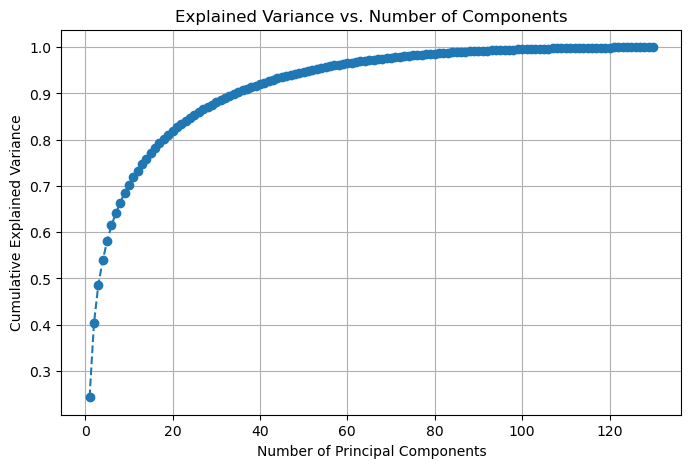

Selected 52 principal components
(130, 52)


In [60]:
pca = PCA()

# Fit PCA on standardized training data
pca.fit(data_training_standardized_df)

# Transform data into principal components
X_pca = pca.transform(data_training_standardized_df)

# Get cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative variance to find the number of components with a acceptable variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

# Choose number of components (keeping 95% variance)
optimal_components = np.argmax(explained_variance >= 0.95) + 1

# Apply PCA with optimal components
pca = PCA(n_components=optimal_components)
X_pca_reduced = pca.fit_transform(data_training_standardized_df)

print(f"Selected {optimal_components} principal components")

# Create DataFrame with PCA-transformed features
training_data_selected2 = pd.DataFrame(X_pca_reduced, columns=[f"PC{i+1}" for i in range(optimal_components)])

print(training_data_selected2.shape)  # Check new dimensions


